In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
%matplotlib inline
from tensorflow.keras.datasets import mnist

In [2]:
# Инициализировали карточку
tf.config.list_physical_devices()

2022-06-06 01:16:39.335249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 01:16:39.343479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 01:16:39.343879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

2022-06-06 01:21:16.136539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-06 01:21:16.137392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 01:21:16.137902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 01:21:16.138745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
# Получим итератор
data_iter = iter(train_dataset)

# Получим одну пару (картинка, метка)
x, y = next(data_iter)

In [6]:
# Заметьте, что итератор возвратил TensorFlow тензоры, а не Numpy массивы 
x.shape, y.shape, type(x), type(y)

(TensorShape([28, 28]),
 TensorShape([]),
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

In [7]:
# Вызов методов создаёт новый объект датасета, а не модифицирует исходный!
train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)

# drop_remainder=True говорит датасету не возвращать оставшийся кусок данных, если в нем содержится меньше 128 элементов
train_dataset = train_dataset.batch(128, drop_remainder=True)

next(iter(train_dataset))[0].shape

TensorShape([128, 28, 28])

In [8]:
def normalize(x, y):
    x = tf.cast(x, dtype='float32')
    x = x / 255.
    return x, y


def reshape(x, y):
    x = tf.reshape(x, shape=[-1, 28*28])
    return x, y

In [9]:
# Трансформации могут применяться параллельно на нескольких элементах!
train_dataset = train_dataset.map(normalize, num_parallel_calls=-1)
train_dataset = train_dataset.map(reshape, num_parallel_calls=-1)
# Говорит датасету всегда иметь на готове 8 батчей
train_dataset = train_dataset.prefetch(8)

next(iter(train_dataset))[0].shape

TensorShape([128, 784])

In [10]:
EPOCHS = 5
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_dataset:
        # do something 1
        # do something 2
        pass
    print('Epoch:', epoch)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [11]:
# Создадим также датасет для тестирования модели
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# drop_remainder в данном случае не установлен, поскольку мы хотим протестировать модель на всех экземплярах данных.
# Почему drop_remainder использовался выше? Опять-таки, для демонстрации, что это есть
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.map(normalize, num_parallel_calls=-1)
test_dataset = test_dataset.map(reshape, num_parallel_calls=-1)

next(iter(test_dataset))[0].shape

TensorShape([128, 784])

In [12]:
import tensorflow.keras as K
import tensorflow.keras.layers as L

In [13]:
class LinearReLU(L.Layer):
    def __init__(self, out_d, name=None):
        super().__init__(name=name)
        self.linear = L.Dense(units=out_d)
        self.relu = L.ReLU()
    
    def call(self, x):
        x = self.linear(x)
        # Можно также использовать и tf.nn.relu
        return self.relu(x)

In [14]:
# Заметьте, что этому слою не нужно предоставлять информацию в размерности входных данных.
# Слои в Keras получат информацию о размерности данных во время первого вызова
linear_relu = LinearReLU(10)

In [15]:
# Весов пока что нет
print(len(linear_relu.variables))

0


In [16]:
# Модули
linear_relu.submodules

2022-06-06 01:28:02.368496: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<keras.layers.core.dense.Dense at 0x7fd1181c7760>,
 <keras.layers.advanced_activations.ReLU at 0x7fd118190e50>)

In [17]:
# При первом вызове слои инициализируют свои веса, используя информацию
# о размерности входных тензоров.
linear_relu(np.random.randn(1, 10).astype('float32'))

2022-06-06 01:28:08.643515: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.        , 1.342301  , 0.        , 1.2422862 ,
        0.18055627, 0.30633855, 0.23065552, 0.42221573, 0.34575912]],
      dtype=float32)>

In [18]:
# Теперь веса есть.
print(len(linear_relu.variables))

2


In [57]:
#Построим аналогичную модель, используя Keras

class NN(K.Model):
    def __init__(self, dim=256, n_classes=10, name='neural_network'):
        super().__init__(name=name)
        self.input_layer = L.Dense(units=dim, activation='sigmoid', name='input')
        self.input_layer2 = L.Dense(units=dim, activation='elu', name='input')
        self.classification_head = L.Dense(units=n_classes)
    
    def call(self, x, training=True):
        x = self.input_layer(x, training=training)
        x = self.input_layer2(x, training=training)
        x = self.classification_head(x, training=training)
        return tf.nn.softmax(x)

In [58]:
model = NN()

In [59]:
x = next(iter(train_dataset))[0]

In [60]:
model(x)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.05970412, 0.07625766, 0.11295817, ..., 0.07240326, 0.13319908,
        0.03042493],
       [0.05944432, 0.10208542, 0.09062438, ..., 0.05905468, 0.10844568,
        0.03568229],
       [0.06060754, 0.10739748, 0.1049589 , ..., 0.06904776, 0.12525538,
        0.02763786],
       ...,
       [0.05318289, 0.08877575, 0.12197378, ..., 0.07579756, 0.11667497,
        0.0258332 ],
       [0.04652612, 0.10505725, 0.10204452, ..., 0.06588491, 0.12494352,
        0.03185739],
       [0.06113286, 0.09353364, 0.10749541, ..., 0.06949957, 0.11087116,
        0.02694851]], dtype=float32)>

In [61]:
loss = K.losses.SparseCategoricalCrossentropy()
accuracy = K.metrics.SparseCategoricalAccuracy()
optim = tf.optimizers.Adam()

EPOCHS = 5

In [62]:
model.compile(optimizer=optim, loss=loss, metrics=[accuracy])

In [63]:
info = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

Epoch 1/5
468/468 [==============================] - 2s 4ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.2584 - val_sparse_categorical_accuracy: 0.9240
Epoch 2/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2256 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.1901 - val_sparse_categorical_accuracy: 0.9445
Epoch 3/5
468/468 [==============================] - 2s 4ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.1318 - val_sparse_categorical_accuracy: 0.9596
Epoch 4/5
468/468 [==============================] - 2s 4ms/step - loss: 0.1198 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.1168 - val_sparse_categorical_accuracy: 0.9642
Epoch 5/5
468/468 [==============================] - 2s 4ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.0995 - val_sparse_categorical_accuracy: 0.9708


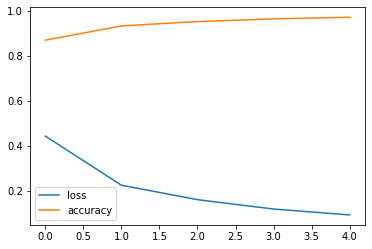

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(info.history['loss'], label='loss')
plt.plot(info.history['sparse_categorical_accuracy'], label='accuracy')
plt.legend()

In [65]:
# Также есть отдельный метод для тестирования
model.evaluate(test_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9708


[0.09949963539838791, 0.97079998254776]